In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import pickle 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import corner

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
tf.__version__

'2.8.0'

In [2]:
import scipy.integrate as integrate
import scipy.special as special     
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [3]:
train_params = np.load('LHS_params_7dim8000.npz')                  

In [4]:
print(train_params.files)                                       # Each of the keys has an 'np.array' of values

['h', 'omega_b', 'omega_cdm', 'ns', 'z', 'lnAs', 'w']


In [5]:
#print(train_params['omega_b'])

n_samples = len(train_params['h'])
print('number of training samples: ', len(train_params['omega_b'])) 

number of training samples:  8000


In [6]:
cosmo_params = np.zeros((len(train_params['omega_b']), 7))
print(cosmo_params[199])

cosmo_params[:, 0] = train_params['h']
cosmo_params[:, 1] = train_params['omega_b']
cosmo_params[:, 2] = train_params['omega_cdm']
cosmo_params[:, 3] = train_params['ns']
cosmo_params[:, 4] = train_params['z']
cosmo_params[:, 5] = train_params['lnAs']
cosmo_params[:, 6] = train_params['w']

[0. 0. 0. 0. 0. 0. 0.]


In [7]:
print(cosmo_params[0])
print(cosmo_params[7999])

[ 0.69722715  0.02436992  0.11675834  1.00530566  4.12614077  3.67425928
 -0.93045381]
[ 0.6535817   0.02008801  0.1867921   0.96099387  1.51268909  2.75764471
 -0.78148519]


In [8]:
len(train_params['h'])

8000

In [9]:
#%%time
## Training input params:
h = cosmo_params[:, 0]
# ombh2:
omega_b = cosmo_params[:, 1]
# omch2:
omega_c = cosmo_params[:, 2]

ns = cosmo_params[:, 3]

z = cosmo_params[:, 4]

lnAs = cosmo_params[:, 5]

w = cosmo_params[:, 6]

In [10]:
with open('pk_data_7dim8000.pkl', 'rb') as f:
    pk_matrix = pickle.load(f)

In [11]:
# Training input params and output param:

train_H0 = 100*h                               #1x8000                     # np.arrays, sizes len(train_params['h'])
train_omega_b = omega_b                        #1x8000
train_omega_c = omega_c                        #1x8000
train_ns = ns                                  #1x8000
train_z = z                                    #1x8000
train_lnAs = lnAs                              #1x8000
train_w = w                                    #1x8000
train_pk = pk_matrix                           #8000x500                 # don't need kh, stays the same

In [12]:
input_params = np.vstack([train_H0, train_omega_b, train_omega_c, train_ns, train_z, train_lnAs, train_w])        # n_samples = no. of rows

input_params_transpose = np.transpose(input_params)
print(np.shape(input_params_transpose))
print(np.shape(train_pk))

input_data = pd.DataFrame(input_params_transpose)
input_data.columns = ['H0', 'Omega_b', 'Omega_cdm', 'ns', 'z', 'lnAs', 'w']

output_data = pd.DataFrame(train_pk) 
print(np.shape(input_data))
print( input_data)                                                         #1400x3
print(np.shape(output_data))

(8000, 7)
(8000, 500)
(8000, 7)
             H0   Omega_b  Omega_cdm        ns         z      lnAs         w
0     69.722715  0.024370   0.116758  1.005306  4.126141  3.674259 -0.930454
1     74.127266  0.023610   0.097956  0.896620  4.429929  2.627141 -1.188224
2     66.878360  0.023529   0.234673  0.882444  3.211651  2.752769 -0.726691
3     70.980873  0.023553   0.154563  0.958189  2.639705  3.269259 -1.350581
4     69.688711  0.023014   0.091380  0.904972  4.728091  3.046931 -1.147606
...         ...       ...        ...       ...       ...       ...       ...
7995  68.424553  0.018129   0.219771  0.916087  3.384798  3.706438 -1.470634
7996  76.443555  0.021942   0.204244  0.988049  2.942243  3.202300 -1.407176
7997  75.991499  0.018383   0.054076  1.009386  2.730966  3.588936 -1.316377
7998  71.264908  0.024042   0.142537  0.949050  0.121265  3.531079 -1.196212
7999  65.358170  0.020088   0.186792  0.960994  1.512689  2.757645 -0.781485

[8000 rows x 7 columns]
(8000, 500)


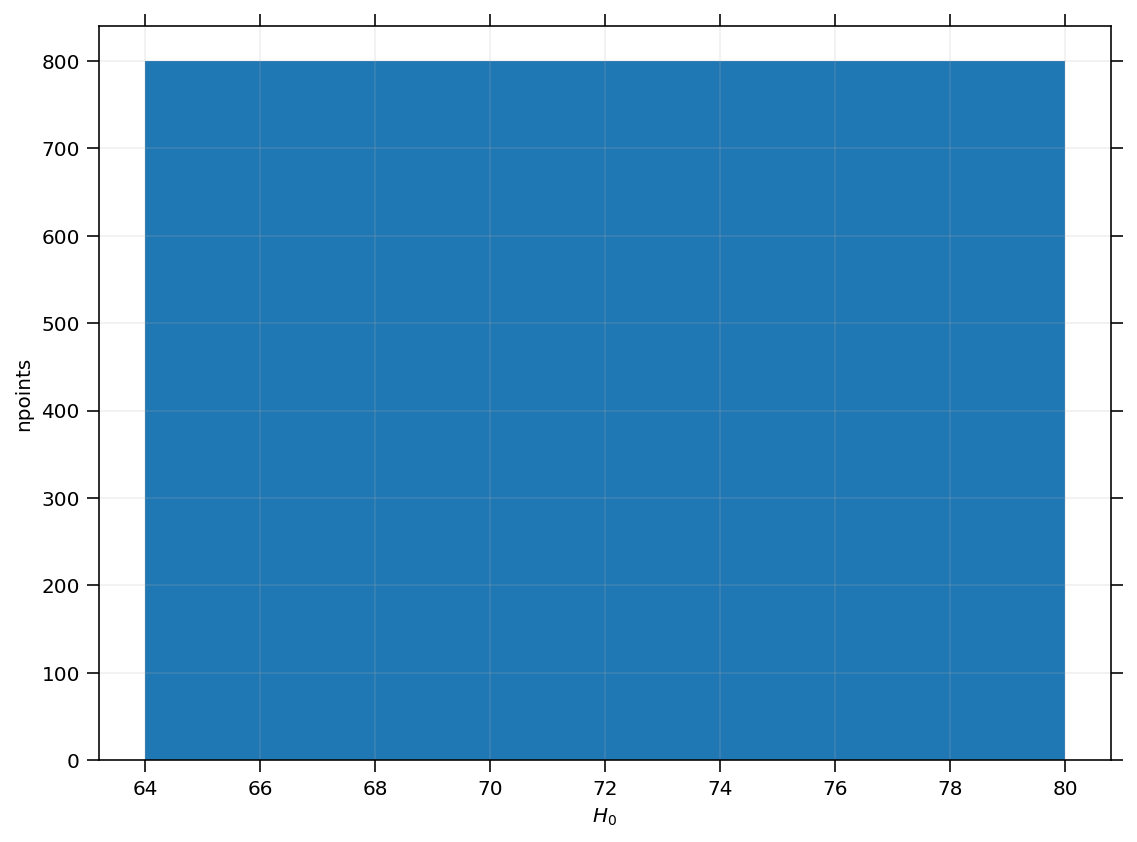

In [13]:
plt.figure(figsize = (8,6))
plt.hist(input_data['H0'])             #bins = 10 by default (binsize)
#plt.hist(input_data['Omega_b'])
#plt.hist(input_data['Omega_cdm'])
plt.xlabel(r'$H_{0}$')
plt.ylabel('npoints')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.tight_layout()



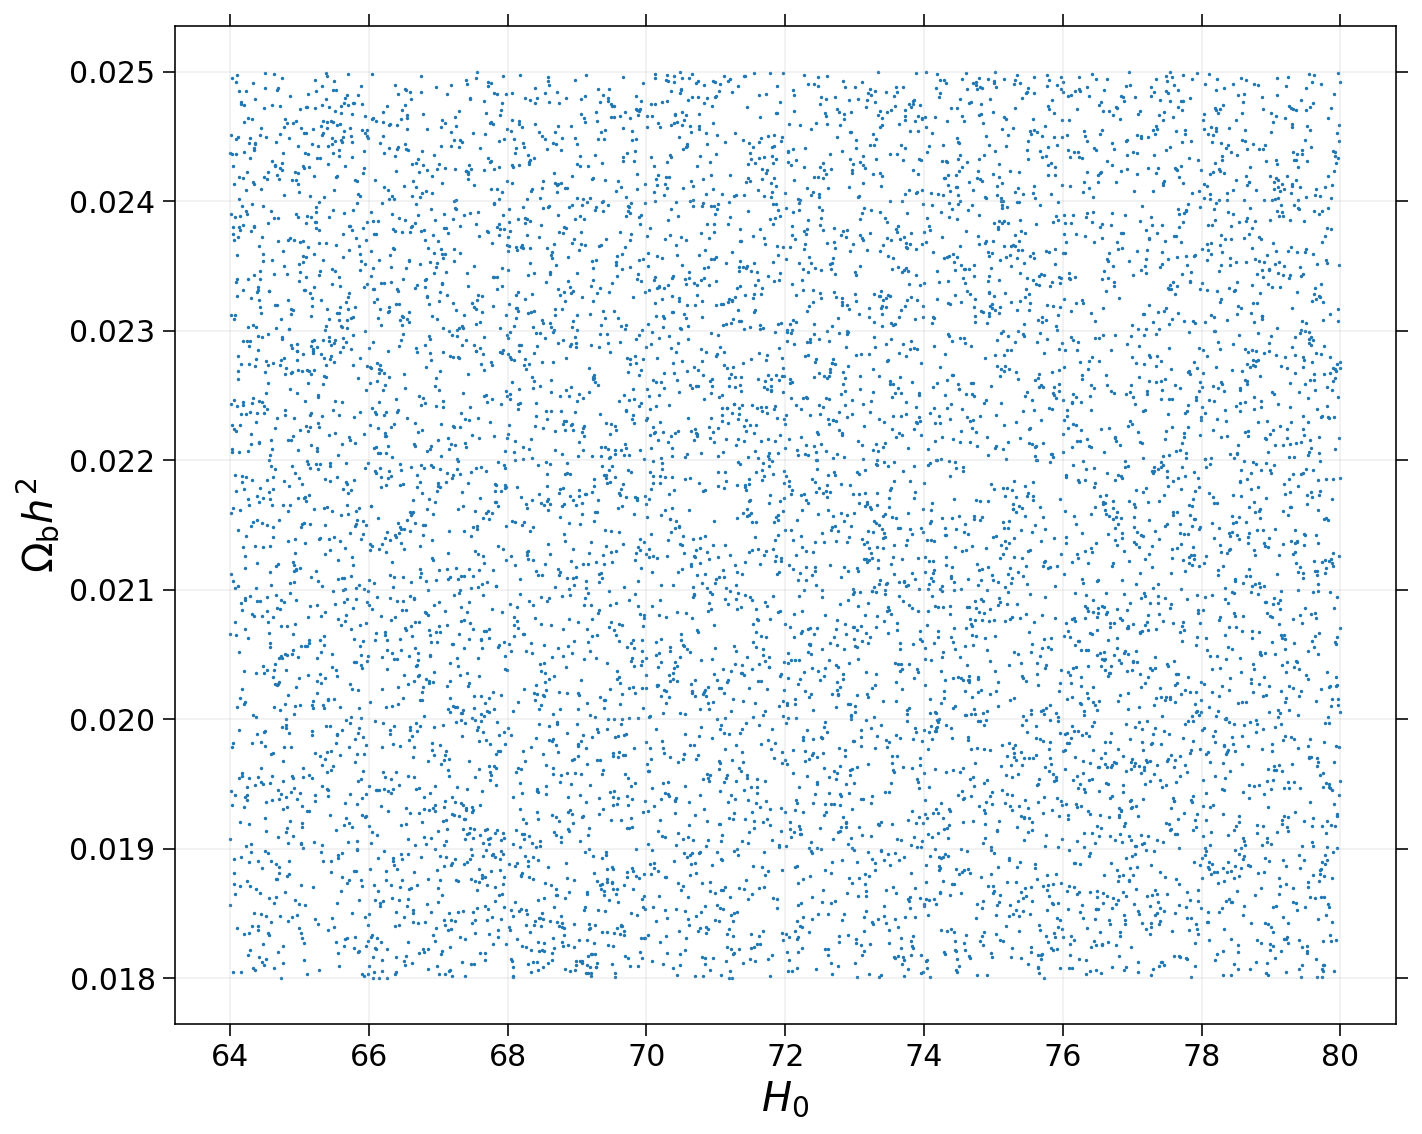

In [14]:
plt.figure(figsize = (10,8))
plt.scatter(input_data['H0'], input_data['Omega_b'], s=0.5)
plt.xlabel(r'$H_{0}$')
plt.ylabel(r'$\Omega_{\mathrm{b}}h^{2}$')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.savefig('LHS_2dim.jpg')
plt.tight_layout()

In [15]:
# Standardising:

train_input_data = StandardScaler()
test_output_data = StandardScaler()

scaled_input = train_input_data.fit(input_data.values)                    # Compute the mean and std to be used for later scaling
scaled_output = test_output_data.fit(output_data.values)

# Generating the standardized values of input and output:
X = scaled_input.transform(input_data.values)                             # Perform standardisation by centring and scaling
y = scaled_output.transform(output_data.values)                           # z = (x - u) / s
print(X)

[[-0.49298496  1.42006517 -0.57569039 ...  1.12648255  1.13037967
   0.460076  ]
 [ 0.46050901  1.04421014 -0.90131595 ...  1.33692673 -1.65952119
  -0.53195611]
 [-1.10872903  1.00393996  1.46639753 ...  0.49298496 -1.32480237
   1.24426201]
 ...
 [ 0.86407685 -1.54217475 -1.66125324 ...  0.15999819  0.903048
  -1.02515758]
 [-0.15913217  1.2576854  -0.12925429 ... -1.64782985  0.74889547
  -0.56270001]
 [-1.43781869 -0.698666    0.6371782  ... -0.68394357 -1.31181199
   1.03338482]]


-1.7318343147478867 1.731834314747888
-6.324859094446577 10.161470992411216


(array([[800., 800., 800., 800., 800., 800., 800., 800., 800., 800.],
        [800., 800., 800., 800., 800., 800., 800., 800., 800., 800.],
        [800., 800., 800., 800., 800., 800., 800., 800., 800., 800.],
        [800., 800., 800., 800., 800., 800., 800., 800., 800., 800.],
        [800., 800., 800., 800., 800., 800., 800., 800., 800., 800.],
        [800., 800., 800., 800., 800., 800., 800., 800., 800., 800.],
        [800., 800., 800., 800., 800., 800., 800., 800., 800., 800.]]),
 array([-1.73183431e+00, -1.38546745e+00, -1.03910059e+00, -6.92733726e-01,
        -3.46366863e-01,  6.66133815e-16,  3.46366863e-01,  6.92733726e-01,
         1.03910059e+00,  1.38546745e+00,  1.73183431e+00]),
 <a list of 7 BarContainer objects>)

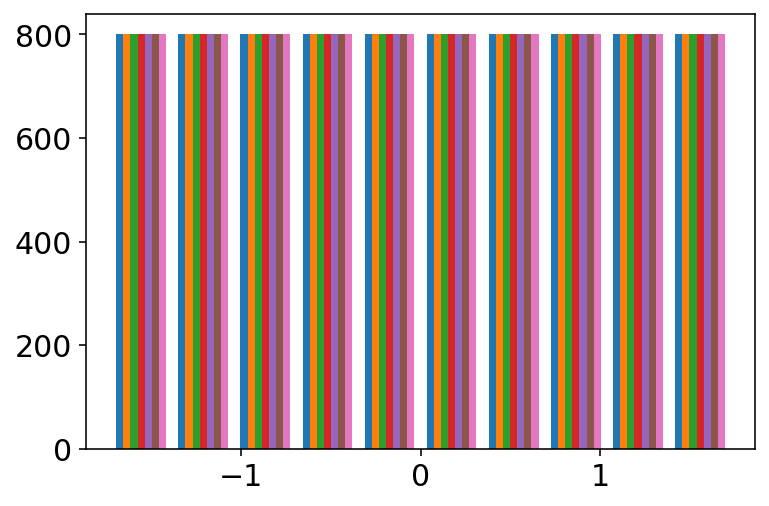

In [16]:
print(X.min(), X.max())
print(y.min(), y.max())
plt.hist(X)

In [17]:
# Storing the fit object for later reference

# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print(np.shape(X_train))    # 6800x7
print(X_train.shape[1])     # 7

(6800, 7)
7


In [18]:
print(X_train)

[[ 7.85918060e-02  6.98666000e-01  2.53095926e-01 ...  1.13817390e+00
  -7.38286662e-02 -9.28812253e-02]
 [ 1.40729129e-02 -1.16112357e+00 -2.16722859e-01 ... -9.68432915e-01
  -1.31874019e+00 -9.06079086e-01]
 [-1.22044631e+00 -1.29838860e+00 -2.95964184e-01 ...  1.65735613e+00
   9.89650538e-01 -1.57118660e+00]
 ...
 [ 7.33956535e-02  1.02429155e+00  4.37992351e-01 ...  5.17233676e-01
  -1.62163258e-01  3.57235482e-02]
 [ 1.64306671e+00 -1.21178606e+00  2.26682151e-01 ... -1.91608122e-01
   1.27673796e+00  1.67381061e+00]
 [ 1.05287039e+00 -1.40404370e+00  1.54953597e+00 ...  3.64813204e-01
  -1.41270395e+00  6.49519058e-04]]


In [19]:
print("y_test samples, pts:", np.shape(y_test))
print("y_train samples, pts:", np.shape(y_train))
print("X_train samples, pts:", np.shape(X_train))
print("X_test ssamples, pts:",np.shape(X_test))
print("X_train:", X_train)
print("X_test:", X_test)

y_test samples, pts: (1200, 500)
y_train samples, pts: (6800, 500)
X_train samples, pts: (6800, 7)
X_test ssamples, pts: (1200, 7)
X_train: [[ 7.85918060e-02  6.98666000e-01  2.53095926e-01 ...  1.13817390e+00
  -7.38286662e-02 -9.28812253e-02]
 [ 1.40729129e-02 -1.16112357e+00 -2.16722859e-01 ... -9.68432915e-01
  -1.31874019e+00 -9.06079086e-01]
 [-1.22044631e+00 -1.29838860e+00 -2.95964184e-01 ...  1.65735613e+00
   9.89650538e-01 -1.57118660e+00]
 ...
 [ 7.33956535e-02  1.02429155e+00  4.37992351e-01 ...  5.17233676e-01
  -1.62163258e-01  3.57235482e-02]
 [ 1.64306671e+00 -1.21178606e+00  2.26682151e-01 ... -1.91608122e-01
   1.27673796e+00  1.67381061e+00]
 [ 1.05287039e+00 -1.40404370e+00  1.54953597e+00 ...  3.64813204e-01
  -1.41270395e+00  6.49519058e-04]]
X_test: [[-1.39235235  0.94634927 -1.09530564 ...  1.08015019  0.77487624
   1.19663061]
 [ 0.63891025 -1.03728194  1.47765586 ...  1.35684531  1.19792965
   0.23880651]
 [ 1.72533912  1.40317767 -0.96366978 ... -0.73070894 

In [24]:
%%time
#ADAPTIVE LEARNING RATE:
#Building the NN:

tf_model = Sequential()
# Defining the input layer of the model
tf_model.add(Dense(units=500, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
# Initializers define the way to set the initial random weights of Keras layers (generate no.s from normal dist. in this case)

# Defining 1st Hidden layer of the model
tf_model.add(Dense(units=500, kernel_initializer='normal', activation='relu'))

tf_model.add(Dropout(0.1))

# Defining 2nd Hidden layer of the model
tf_model.add(Dense(units=500, kernel_initializer='normal', activation='relu'))

# Defining 3rd Hidden layer of the model
#tf_model.add(Dense(units=500, kernel_initializer='normal', activation='relu'))

# Defining the 4th hidden layer of the model
#tf_model.add(Dense(units=350, kernel_initializer='normal', activation='relu')) 

#Defining the output layer of the model
tf_model.add(Dense(500, kernel_initializer='normal'))
 
#opt=tf.keras.optimizers.RMSprop(learning_rate=4e-05, epsilon=1e-08)
opt=tf.keras.optimizers.Adam(learning_rate=2e-05, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
# Compiling the model
tf_model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
 
# Fitting the ANN to the Training set
hist_ = tf_model.fit(X_train, y_train, batch_size = 50, epochs = 500, validation_split=0.2, verbose=1)
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test))/y_test))*100
print(np.shape(100-MAPE))
print('Accuracy:', 100-MAPE)
#lr=0.001
#90.0394087282938, RMSprop opt., lr=1e-04, epsilon=1e-08, 500 epochs, 500 units, Dropout 0.2, 2 hidden layers 
#89.92352064800525, lr=4e-05
#87.288041475825, lr=4e-05, 600 units
#89.6772378365107, lr=4e-05, 500 units, dropout=0.1
#89.6772378365107, lr=0.001, 500 units, dropout=0.1, adam opt.
#90.85019412805444, lr=1e-04, 500 units, dropout=0.1, adam opt. !!
#89.10977293694084, lr=8e-05, 500 units, dropout=0.1, adam opt.
#82.71311320358983 lr=1e-04, 500 units, dropout=0.1, adam opt., 3 hidden layers
#89.09635850464215, lr=1e-04, 500 units, dropout=0.1, adam opt.
#90.20444849147174,lr=2e-05, 500 units, dropout=0.1, adam opt.
tf_model.summary()

Epoch 1/500
109/109 [==============================] - 1s 8ms/step - loss: 0.9977 - accuracy: 0.0020 - val_loss: 0.9022 - val_accuracy: 0.0022
Epoch 2/500
109/109 [==============================] - 1s 7ms/step - loss: 0.8635 - accuracy: 0.0017 - val_loss: 0.6359 - val_accuracy: 7.3529e-04
Epoch 3/500
109/109 [==============================] - 1s 7ms/step - loss: 0.4719 - accuracy: 3.6765e-04 - val_loss: 0.2655 - val_accuracy: 0.0000e+00
Epoch 4/500
109/109 [==============================] - 1s 7ms/step - loss: 0.2503 - accuracy: 9.1912e-04 - val_loss: 0.1875 - val_accuracy: 0.0015
Epoch 5/500
109/109 [==============================] - 1s 7ms/step - loss: 0.2005 - accuracy: 0.0018 - val_loss: 0.1598 - val_accuracy: 0.0022
Epoch 6/500
109/109 [==============================] - 1s 7ms/step - loss: 0.1741 - accuracy: 0.0031 - val_loss: 0.1379 - val_accuracy: 0.0110
Epoch 7/500
109/109 [==============================] - 1s 7ms/step - loss: 0.1512 - accuracy: 0.0092 - val_loss: 0.1183 - val_

Epoch 58/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0231 - accuracy: 0.2024 - val_loss: 0.0203 - val_accuracy: 0.2044
Epoch 59/500
109/109 [==============================] - 1s 10ms/step - loss: 0.0229 - accuracy: 0.2075 - val_loss: 0.0190 - val_accuracy: 0.2088
Epoch 60/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0222 - accuracy: 0.2132 - val_loss: 0.0184 - val_accuracy: 0.2169
Epoch 61/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0219 - accuracy: 0.2119 - val_loss: 0.0179 - val_accuracy: 0.2228
Epoch 62/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0211 - accuracy: 0.2164 - val_loss: 0.0172 - val_accuracy: 0.2287
Epoch 63/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0210 - accuracy: 0.2134 - val_loss: 0.0170 - val_accuracy: 0.2228
Epoch 64/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0201 - accuracy: 0.2278 - val_loss: 0.0163 - val_accuracy

Epoch 115/500
109/109 [==============================] - 1s 7ms/step - loss: 0.0073 - accuracy: 0.3669 - val_loss: 0.0048 - val_accuracy: 0.4316
Epoch 116/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0071 - accuracy: 0.3643 - val_loss: 0.0050 - val_accuracy: 0.4346
Epoch 117/500
109/109 [==============================] - 1s 7ms/step - loss: 0.0071 - accuracy: 0.3531 - val_loss: 0.0047 - val_accuracy: 0.4404
Epoch 118/500
109/109 [==============================] - 1s 7ms/step - loss: 0.0070 - accuracy: 0.3748 - val_loss: 0.0045 - val_accuracy: 0.4309
Epoch 119/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0068 - accuracy: 0.3728 - val_loss: 0.0045 - val_accuracy: 0.4368
Epoch 120/500
109/109 [==============================] - 1s 7ms/step - loss: 0.0068 - accuracy: 0.3726 - val_loss: 0.0044 - val_accuracy: 0.4404
Epoch 121/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0065 - accuracy: 0.3739 - val_loss: 0.0044 - val_ac

109/109 [==============================] - 1s 8ms/step - loss: 0.0039 - accuracy: 0.4331 - val_loss: 0.0025 - val_accuracy: 0.5309
Epoch 172/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0039 - accuracy: 0.4430 - val_loss: 0.0025 - val_accuracy: 0.5176
Epoch 173/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0039 - accuracy: 0.4381 - val_loss: 0.0024 - val_accuracy: 0.5176
Epoch 174/500
109/109 [==============================] - 1s 7ms/step - loss: 0.0038 - accuracy: 0.4432 - val_loss: 0.0023 - val_accuracy: 0.5199
Epoch 175/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0037 - accuracy: 0.4384 - val_loss: 0.0023 - val_accuracy: 0.5169
Epoch 176/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0037 - accuracy: 0.4397 - val_loss: 0.0026 - val_accuracy: 0.5257
Epoch 177/500
109/109 [==============================] - 1s 7ms/step - loss: 0.0039 - accuracy: 0.4450 - val_loss: 0.0023 - val_accuracy: 0.5221

109/109 [==============================] - 1s 8ms/step - loss: 0.0027 - accuracy: 0.4847 - val_loss: 0.0018 - val_accuracy: 0.5625
Epoch 228/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0028 - accuracy: 0.4818 - val_loss: 0.0017 - val_accuracy: 0.5713
Epoch 229/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0029 - accuracy: 0.4759 - val_loss: 0.0017 - val_accuracy: 0.5618
Epoch 230/500
109/109 [==============================] - 1s 10ms/step - loss: 0.0029 - accuracy: 0.4851 - val_loss: 0.0018 - val_accuracy: 0.5713
Epoch 231/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0028 - accuracy: 0.4820 - val_loss: 0.0018 - val_accuracy: 0.5640
Epoch 232/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0028 - accuracy: 0.4812 - val_loss: 0.0017 - val_accuracy: 0.5574
Epoch 233/500
109/109 [==============================] - 1s 10ms/step - loss: 0.0029 - accuracy: 0.4938 - val_loss: 0.0017 - val_accuracy: 0.56

109/109 [==============================] - 1s 8ms/step - loss: 0.0022 - accuracy: 0.5143 - val_loss: 0.0015 - val_accuracy: 0.5985
Epoch 284/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0023 - accuracy: 0.5099 - val_loss: 0.0015 - val_accuracy: 0.6029
Epoch 285/500
109/109 [==============================] - 1s 12ms/step - loss: 0.0023 - accuracy: 0.5090 - val_loss: 0.0015 - val_accuracy: 0.6051
Epoch 286/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0023 - accuracy: 0.5018 - val_loss: 0.0015 - val_accuracy: 0.5904
Epoch 287/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0024 - accuracy: 0.5094 - val_loss: 0.0014 - val_accuracy: 0.5926
Epoch 288/500
109/109 [==============================] - 1s 11ms/step - loss: 0.0023 - accuracy: 0.5079 - val_loss: 0.0016 - val_accuracy: 0.5919
Epoch 289/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0022 - accuracy: 0.5103 - val_loss: 0.0015 - val_accuracy: 0.60

109/109 [==============================] - 1s 9ms/step - loss: 0.0020 - accuracy: 0.5401 - val_loss: 0.0013 - val_accuracy: 0.6250
Epoch 340/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0021 - accuracy: 0.5324 - val_loss: 0.0013 - val_accuracy: 0.6169
Epoch 341/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0019 - accuracy: 0.5309 - val_loss: 0.0014 - val_accuracy: 0.6191
Epoch 342/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0019 - accuracy: 0.5355 - val_loss: 0.0012 - val_accuracy: 0.6118
Epoch 343/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0021 - accuracy: 0.5401 - val_loss: 0.0014 - val_accuracy: 0.6103
Epoch 344/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0020 - accuracy: 0.5322 - val_loss: 0.0014 - val_accuracy: 0.6132
Epoch 345/500
109/109 [==============================] - 1s 10ms/step - loss: 0.0020 - accuracy: 0.5301 - val_loss: 0.0014 - val_accuracy: 0.617

109/109 [==============================] - 1s 7ms/step - loss: 0.0017 - accuracy: 0.5522 - val_loss: 0.0013 - val_accuracy: 0.6368
Epoch 396/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0019 - accuracy: 0.5496 - val_loss: 0.0012 - val_accuracy: 0.6375
Epoch 397/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0019 - accuracy: 0.5531 - val_loss: 0.0013 - val_accuracy: 0.6404
Epoch 398/500
109/109 [==============================] - 1s 7ms/step - loss: 0.0018 - accuracy: 0.5572 - val_loss: 0.0012 - val_accuracy: 0.6279
Epoch 399/500
109/109 [==============================] - 1s 7ms/step - loss: 0.0017 - accuracy: 0.5533 - val_loss: 0.0012 - val_accuracy: 0.6390
Epoch 400/500
109/109 [==============================] - 1s 7ms/step - loss: 0.0017 - accuracy: 0.5568 - val_loss: 0.0011 - val_accuracy: 0.6368
Epoch 401/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0018 - accuracy: 0.5498 - val_loss: 0.0011 - val_accuracy: 0.6537

109/109 [==============================] - 1s 7ms/step - loss: 0.0016 - accuracy: 0.5640 - val_loss: 0.0011 - val_accuracy: 0.6316
Epoch 452/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0016 - accuracy: 0.5721 - val_loss: 0.0011 - val_accuracy: 0.6463
Epoch 453/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0015 - accuracy: 0.5689 - val_loss: 0.0012 - val_accuracy: 0.6647
Epoch 454/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0017 - accuracy: 0.5719 - val_loss: 0.0011 - val_accuracy: 0.6559
Epoch 455/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0016 - accuracy: 0.5614 - val_loss: 0.0011 - val_accuracy: 0.6603
Epoch 456/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0016 - accuracy: 0.5634 - val_loss: 0.0013 - val_accuracy: 0.6574
Epoch 457/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0016 - accuracy: 0.5733 - val_loss: 0.0011 - val_accuracy: 0.6596

Total params: 755,500
Trainable params: 755,500
Non-trainable params: 0
_________________________________________________________________
Wall time: 7min 29s


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

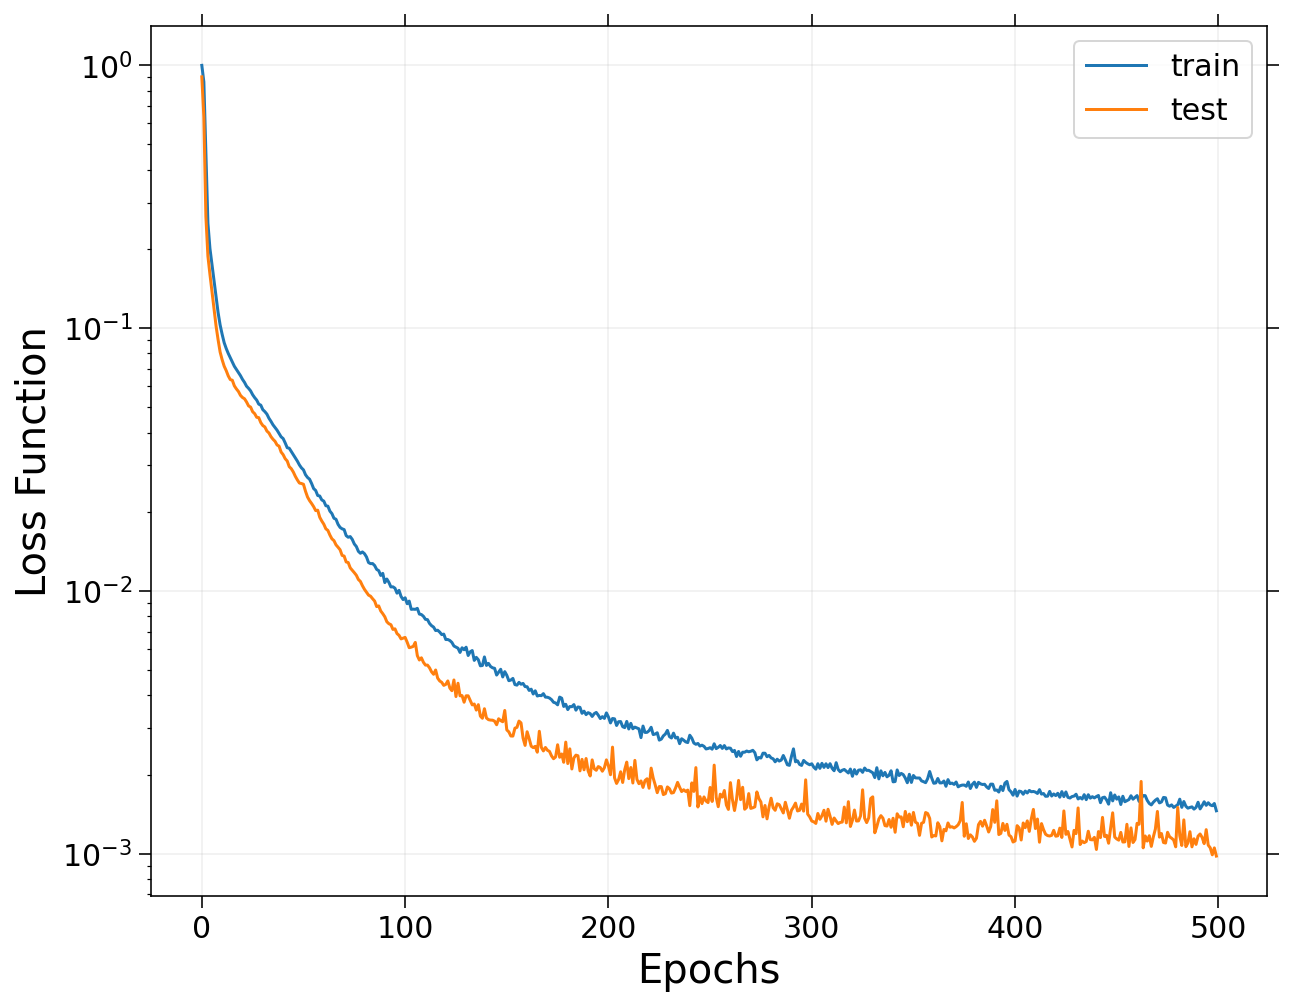

In [27]:
plt.figure(figsize = (10,8))
plt.plot(hist_.history["loss"], label="train")
plt.plot(hist_.history["val_loss"], label="test")
plt.legend(fontsize=15)
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.savefig('Loss_Func_7param.jpg')
plt.tight_layout

H0: 64.0 - 80.0, Omega_b: 0.0180 - 0.0250, Omega_cdm: 0.050 - 0.250, ns: 0.88 - 1.05, z: 0.0 - 5.0, lnAs: 2.60 - 3.90, w: -1.5 - -0.6 67 0.022 0.122 0.965 0.5 2.99 -1.0


parameters:  ['67', '0.022', '0.122', '0.965', '0.5', '2.99', '-1.0']
user_list: [67.0, 0.022, 0.122, 0.965, 0.5, 2.99, -1.0]
cosmo_arr [[ 6.70e+01  2.20e-02  1.22e-01  9.65e-01  5.00e-01  2.99e+00 -1.00e+00]]
cosmo_arr[0] [ 6.70e+01  2.20e-02  1.22e-01  9.65e-01  5.00e-01  2.99e+00 -1.00e+00]
input_scaled [[-1.08239645  0.2474049  -0.48491361  0.         -1.38546745 -0.69273373
   0.19242603]]


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


H0: 67.0 Omega_b: 0.022 Omega_c: 0.122 ns: 0.965 z: 0.5 lnAs: 2.99 w: -1.0


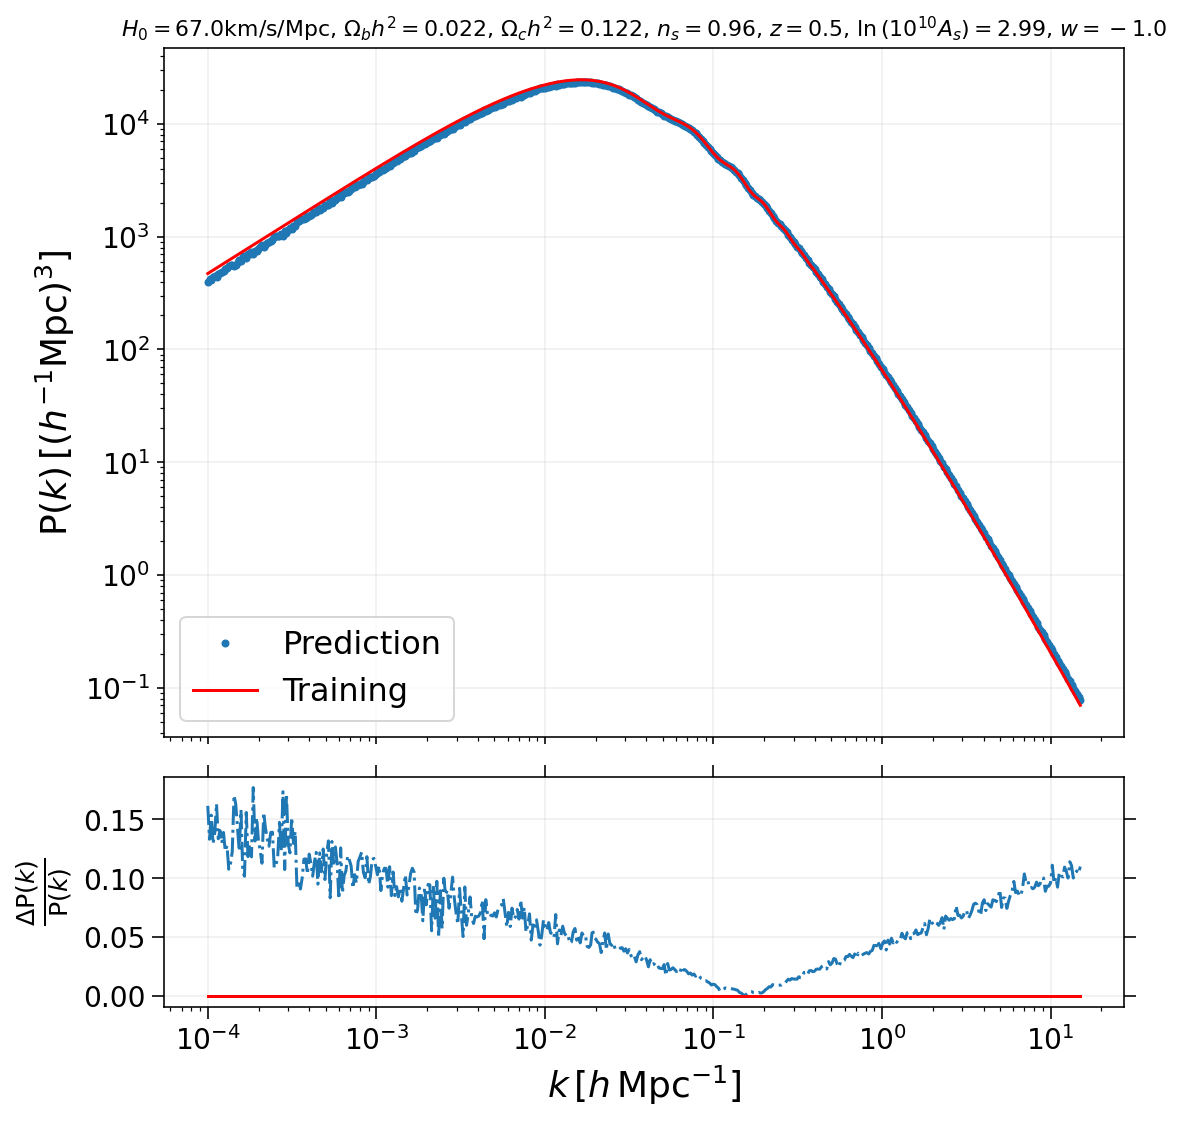

In [36]:
#Define func:

def calc_cosmo():
    input_cosmo_val = input('H0: 64.0 - 80.0, Omega_b: 0.0180 - 0.0250, Omega_cdm: 0.050 - 0.250, ns: 0.88 - 1.05, z: 0.0 - 5.0, lnAs: 2.60 - 3.90, w: -1.5 - -0.6 ')
    print("\n")
    user_list = input_cosmo_val.split()
    print('parameters: ', user_list)

    # convert each item to float type
    for i in range(len(user_list)):
        # convert each item to float type
        user_list[i] = float(user_list[i])
    print("user_list:", user_list)
        
    
    cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
    print('cosmo_arr', cosmo_arr)
    print('cosmo_arr[0]', cosmo_arr[0])
    scaled = train_input_data.fit(input_data)
    input_scaled = scaled.transform(cosmo_arr)
    print('input_scaled', input_scaled)
    
    pred_pk = scaled_output.inverse_transform(tf_model.predict([input_scaled]))
    
    
    #Compute P.S via CAMB:
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=cosmo_arr[0][1], omch2=cosmo_arr[0][2])
    pars.InitPower.set_params(As = np.exp(cosmo_params[i,5])/(10**10), ns=cosmo_params[i,3])
    pars.set_matter_power(redshifts=[cosmo_params[i,4]], kmax=15.0)
    pars.set_dark_energy(w=cosmo_params[i,6], wa=0, dark_energy_model='fluid')

    # Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
    s8_current = np.array(results.get_sigma8())
    s8_fid = np.array([0.8102])
    renorm_s8 = (s8_fid/s8_current)**2
    camb_pk = renorm_s8*camb_pk_cur
    

    print('H0:' , cosmo_arr[0][0], 'Omega_b:', cosmo_arr[0][1], 'Omega_c:', cosmo_arr[0][2], 'ns:', cosmo_arr[0][3], 'z:', cosmo_arr[0][4], 'lnAs:', cosmo_arr[0][5], 'w:', cosmo_arr[0][6])
    #print(pred_pk)
    
    fig, ax = plt.subplots(2,1, sharex=True, figsize = (8,8), gridspec_kw={'height_ratios': [3, 1]})                                            
    ax[0].loglog(camb_kh, pred_pk[0], "C0.")                                    
    #plt.loglog(X_test, y_test, "C1d")
    ax[0].loglog(camb_kh, camb_pk[0], 'r')                              
    #ax[0].set_title('Matter Power Spectrum at $H_{0} = %0.5s \mathregular{(km/s/Mpc)}$, ' %cosmo_arr[0][0] + '$\Omega_{b}h^{2} = %0.6s$, ' %cosmo_arr[0][1] + '$\Omega_{c}h^{2} = %0.6s$, ' %cosmo_arr[0][2] + '$n_{s} = %0.4s$, ' %cosmo_arr[0][3] + '$z = %0.4s$, ' %cosmo_arr[0][4] + '$\ln{(10^{10}A_{s})} = %0.6s$, ' %cosmo_arr[0][5] + '$w = %0.6s$, ' %cosmo_arr[0][6],   fontsize = 12)
    ax[0].set_title('$H_{0} = %0.5s \mathregular{km/s/Mpc}$, ' %cosmo_arr[0][0] + '$\Omega_{b}h^{2} = %0.6s$, ' %cosmo_arr[0][1] + '$\Omega_{c}h^{2} = %0.6s$, ' %cosmo_arr[0][2] + '$n_{s} = %0.4s$, ' %cosmo_arr[0][3] + '$z = %0.4s$, ' %cosmo_arr[0][4] + '$\ln{(10^{10}A_{s})} = %0.6s$, ' %cosmo_arr[0][5] + '$w = %0.6s$' %cosmo_arr[0][6],   fontsize = 11)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(['Prediction', 'Training'], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)
    
    
    #residual plot 
    ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
    ax[1].plot(camb_kh, np.abs((pred_pk[0]-camb_pk[0])/camb_pk[0]), 'C0', linestyle="dashdot") 
    ax[1].plot(camb_kh, np.abs((camb_pk[0]-camb_pk[0])/camb_pk[0]), 'r')
    ax[1].set_yscale('linear')
    fig.tight_layout()
    #ax[1].set_ylim(0, 0.05)
    plt.savefig('NN_MPS_7params.jpg')
    plt.show()
    

Generate = calc_cosmo()

In [ ]:
#show single plot of mps for varying params?